# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import pandas as pd
import tqdm
import gzip
import numpy as np
from pathlib import Path
from urllib.request import urlretrieve

In [2]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        ind_word = self.word2id[word]## finding the index of the word
        # Returns the 1D embedding of a given word
        return self.embeddings[ind_word]
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        if type(word1) == str :
            w1 = self.encode(word1)
            w2 = self.encode(word2)[np.newaxis, :] ## for fast computation
        else :
            w1 = word1; w2 = word2
        return np.dot(w2, w1)/(np.linalg.norm(w1)*np.linalg.norm(w2, axis = 1)) ## cosine similarity
        
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        w1 = self.encode(word)
        sim = self.score(w1, self.embeddings)
        inds = np.argsort(sim)[-k-1:][::-1]
        words = [self.words[i] for i in inds[1:]] ## We don't count the word in input
        return words


In [4]:
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree [0.26449755]
cat dog [0.70786413]
cat pet [0.67533134]
Paris France [0.68929589]
Paris Germany [0.40512423]
Paris baguette [0.29399958]
Paris donut [-0.00658851]
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [5]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        if idf is None:
            sent_emb = []
            sent = []
            for word in sentence.split() :
                try :
                    sent_emb.append(self.word2vec.encode(word))
                    sent.append(word)
                except :
                    pass 
            return np.mean(np.array(sent_emb), axis = 0)
        else:
            # idf-weighted mean of word vectors
            sent_emb = []
            sent = []
            for word in sentence.split() :
                try :
                    sent_emb.append(self.word2vec.encode(word))
                    sent.append(word)
                except :
                    pass
            sent_weights = np.array([idf.get(word, 0) for word in sent])
            return np.average(sent_emb, axis = 0, weights = sent_weights)
            

    def score(self, sentence1, sentence2, idf=None):
        if type(sentence1) == str :
            w1 = self.encode(sentence1, idf)
            w2 = self.encode(sentence2, idf)[np.newaxis, :]
        else :
            w1 = sentence1; w2 = sentence2
        # cosine similarity: use np.dot & np.linalg.norm 
        return np.dot(w2, w1)/(np.linalg.norm(w1)*np.linalg.norm(w2, axis = 1))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        sim = self.score(query, keys)
        inds = np.argsort(sim)[-k-1:][::-1]
        sents = [sentences[i] for i in inds[1:]] ## We don't count the word in input
        return sents
  
    def build_idf(self, sentences):

        print('Building IDF ......')
        words_in_sentences = list(set(''.join(sentences).split()))
        words_in_sentences = np.intersect1d(words_in_sentences, 
                                            self.word2vec.words)   

        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        idf_dict = dict(zip(words_in_sentences, [0.]*len(words_in_sentences)))
        for sentence_ in sentences :
            for word in set(sentence_.split()) :
                try :
                    idf_dict.update({word : 1 + idf_dict[word]})  
                except :
                    pass
        idf_dict = {elt : max(1, np.log(len(sentences)/value)) for elt, value in idf_dict.items() if value != 0}
        return idf_dict   

In [6]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence_ = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence_, sentences)  # BagOfWords-mean
print(sentence_)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence_, sentences, idf)  # BagOfWords-idf
print(sentence_)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
[0.70652206]
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 
Building IDF ......

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
[0.66700471]
1 smiling african american boy . 
1) 1 man singing and 1 man playing a saxophone in a concert . 
2) two women and 1 man walking across the street . 
3) 5 women and 1 man are smiling for the camera . 
4) 3 males and 1 woman enjoying a sporting event 
5) 2 guys facing away from camera , 1 girl smiling at camera with blue shirt , 1 guy with a beverage with a jacket on . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        intersect_words, fr_inds, eng_inds = np.intersect1d(self.fr_word2vec.words, 
                                                          self.en_word2vec.words, 
                                                          return_indices=True)
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        X = self.fr_word2vec.embeddings[fr_inds].T
        Y = self.en_word2vec.embeddings[eng_inds].T
        
        assert X.shape[0] == 300 and Y.shape[0] == 300
        u, _, v = np.linalg.svd(Y.dot(X.T))
        W = u.dot(v)
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.T)
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        index_word = self.fr_word2vec.words.index(fr_word)
        fr_eng_emb = self.aligned_fr_embeddings[index_word] ## projection of the french word into the english space
        sim = np.zeros(len(self.en_word2vec.words))
        i = 0
        for eng_word in self.en_word2vec.embeddings :
            sim[i] = np.dot(fr_eng_emb, eng_word)/(np.linalg.norm(fr_eng_emb)*\
                                                          np.linalg.norm(eng_word))
            i += 1
        inds = np.argsort(sim)[-k-1:][::-1]
        words = [self.en_word2vec.words[i] for i in inds[1:]] ## We don't count the input word 
        return words

In [8]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "kitten"
en: "kitty"
en: "pet"
----------
fr: "chien"
en: "cat"
en: "pet"
en: "pup"
----------
fr: "voiture"
en: "vehicle"
en: "automobile"
en: "motorbike"
----------
fr: "zut"
en: "Ah"
en: "ah"
en: "nope"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [9]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'
with open(test_filepath, 'r') as f:
    sentences_test = [line.strip('\n') for line in f]  
# TYPE CODE HERE
def process_sentences(train_filepath) :
    with open(train_filepath, 'r') as f:
        sentences = [line.strip('\n') for line in f]
    sent = []; y = []
    for sentence in sentences :
        y.append(int(sentence[0]))
        sent.append(sentence[2:])
    return sent, y 
sentences_train, y_train = process_sentences(train_filepath) 
sentences_dev, y_dev =  process_sentences(dev_filepath) 

In [10]:
# 2 - Encode sentences with the BoV model above
sentence2vec = BagOfWords(word2vec)
idf = sentence2vec.build_idf(sentences_train)
X_train = np.array([sentence2vec.encode(sentence) for sentence in sentences_train])
X_dev = np.array([sentence2vec.encode(sentence) for sentence in sentences_dev])
X_test = np.array([sentence2vec.encode(sentence) for sentence in sentences_test])

X_train_idf = np.array([sentence2vec.encode(sentence, idf) for sentence in sentences_train])
X_dev_idf = np.array([sentence2vec.encode(sentence, idf) for sentence in sentences_dev])
X_test_idf = np.array([sentence2vec.encode(sentence, idf) for sentence in sentences_test])

Building IDF ......


In [11]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
from sklearn import linear_model
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_dev_tr = scaler.transform(X_dev)
logistic = linear_model.LogisticRegression()
C = np.logspace(-3, -1, 30)
params = dict(C=C, solver=['lbfgs'], max_iter=[1000], penalty=['l2'], multi_class=['auto'])
clf = GridSearchCV(logistic, params, cv=2, verbose=0, n_jobs = 6)
best_model = clf.fit(X_train_tr, y_train)
y_pred = best_model.predict(X_dev_tr)
print('Accuracy without IDF', accuracy_score(y_pred, y_dev))

scaler_idf = StandardScaler()
X_train_tr = scaler_idf.fit_transform(X_train_idf)
X_dev_tr = scaler_idf.transform(X_dev_idf)
logistic = linear_model.LogisticRegression()
C = np.logspace(-4, -2, 30)
params = dict(C=C, solver=['lbfgs'], max_iter=[1000], penalty=['l2'], multi_class=['auto'])
clf_idf = GridSearchCV(logistic, params, cv=2, verbose=0, n_jobs = 6)
best_model_idf = clf_idf.fit(X_train_tr, y_train)
y_pred = best_model_idf.predict(X_dev_tr)
print('Accuracy with IDF', accuracy_score(y_pred, y_dev))
# TYPE CODE HERE

Accuracy without IDF 0.40962761126248864
Accuracy with IDF 0.40599455040871935


In [13]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
X_test_tr = scaler.transform(X_test)
y_test = best_model.predict(X_test_tr)
y_test = y_test.astype(int)
np.savetxt('logreg_bov_y_test_sst.txt', y_test, fmt='%d')
# TYPE CODE HERE

In [14]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
clf_rf = RandomForestClassifier(class_weight = 'balanced')
params = {'n_estimators': 200, ## optimal parameters obtained with a grid search cross validation
         'min_samples_split': 4,
         'min_samples_leaf': 4,
         'max_depth': 20,
         'criterion': 'gini'}
clf_rf = clf_rf.set_params(**params)
clf_rf.fit(X_train_tr, y_train);
print('Accuracy without IDF', accuracy_score(y_pred, y_dev))
X_test_tr = scaler.transform(X_test)
y_test = clf_rf.predict(X_test_tr)
y_test = y_test.astype(int)
np.savetxt('randomforest_bov_y_test_sst.txt', y_test, fmt='%d')

Accuracy without IDF 0.40599455040871935


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [26]:
import tensorflow as tf
from keras import backend as K

In [16]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
from keras.preprocessing import text
X_train = [text.one_hot(sentence, n=20000) for sentence in sentences_train]
X_dev = [text.one_hot(sentence, n=20000) for sentence in sentences_dev]
X_test = [text.one_hot(sentence, n=20000) for sentence in sentences_test]

# TYPE CODE HERE

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [17]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/
from keras.preprocessing import sequence
import pandas as pd
X_train = sequence.pad_sequences(X_train, maxlen=30)
X_dev = sequence.pad_sequences(X_dev, maxlen=30)
X_test = sequence.pad_sequences(X_test, maxlen=30)

y_train_ = pd.get_dummies(y_train).values
y_dev_ = pd.get_dummies(y_dev).values

## 4.2 - Design and train your model

In [27]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout

embed_dim  = 200  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 20000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [20]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         4000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 4,068,165
Trainable params: 4,068,165
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)

# ADAPT CODE BELOW
bs = 128
n_epochs = 5
history = model.fit(X_train, y_train_, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, y_dev_))

Train on 8544 samples, validate on 1101 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
8544/8544 [==============================] - 7s 784us/sample - loss: 1.5729 - acc: 0.2845 - val_loss: 1.5529 - val_acc: 0.2625
Epoch 2/5
8544/8544 [==============================] - 6s 740us/sample - loss: 1.4294 - acc: 0.3680 - val_loss: 1.3964 - val_acc: 0.3724
Epoch 3/5
8544/8544 [==============================] - 6s 667us/sample - loss: 1.1641 - acc: 0.4574 - val_loss: 1.4255 - val_acc: 0.3851
Epoch 4/5
8544/8544 [==============================] - 6s 651us/sample - loss: 0.9428 - acc: 0.5603 - val_loss: 1.5949 - val_acc: 0.3806
Epoch 5/5
8544/8544 [==============================] - 6s 734us/sample - loss: 0.7332 - acc: 0.6848 - val_loss: 1.7401 - val_acc: 0.3787


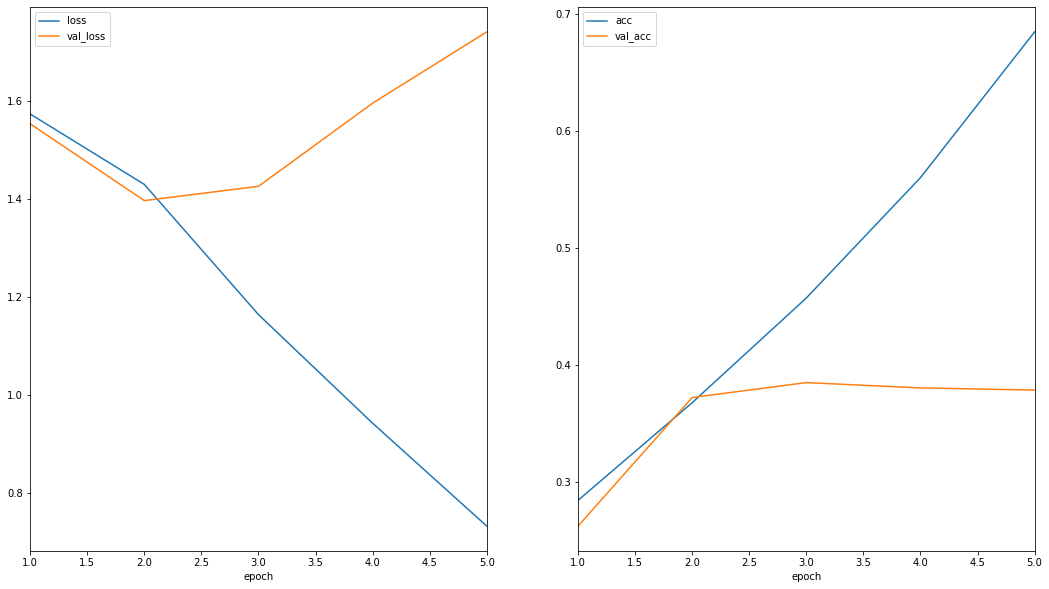

In [23]:
df = pd.DataFrame.from_dict(history.history, orient = 'index').T
df['epoch'] = df.index + 1
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize = (18, 10), sharex = True)
df.plot(x = 'epoch', y = ['loss', 'val_loss'], ax = axes[0])
df.plot(x = 'epoch', y = ['acc', 'val_acc'], ax = axes[1])
fig.savefig('weak_model_epochs.png')

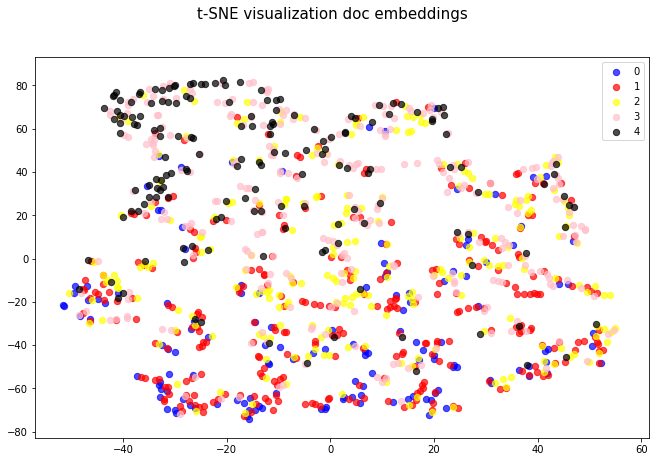

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def visualize_doc_embeddings(my_doc_embs, my_colors, my_labels, my_name):
    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2,perplexity=10) #https://lvdmaaten.github.io/tsne/
    doc_embs_pca = my_pca.fit_transform(my_doc_embs) 
    doc_embs_tsne = my_tsne.fit_transform(doc_embs_pca)
    
    fig, ax = plt.subplots()
    
    for label in list(set(my_labels)):
        idxs = [idx for idx,elt in enumerate(my_labels) if elt==label]
        ax.scatter(doc_embs_tsne[idxs,0], 
                   doc_embs_tsne[idxs,1], 
                   c = my_colors[label],
                   label=str(label),
                   alpha=0.7,
                   s=40)
    
    ax.legend(scatterpoints=1)
    fig.suptitle('t-SNE visualization doc embeddings',fontsize=15)
    fig.set_size_inches(11,7)
    fig.savefig(my_name + '.png')
    
get_doc_embedding = K.function([model.layers[0].input, K.learning_phase()],
                                [model.layers[-2].output])
doc_embs = get_doc_embedding([np.array(X_dev),0])[0]
visualize_doc_embeddings(doc_embs,['blue','red', 'yellow', 'pink', 'black'], y_dev,'no_inno_emb')

In [25]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.
y_test = model.predict_classes(X_test)
np.savetxt('logreg_lstm_y_test_sst.txt', y_test, fmt='%d')


## 4.3 - innovate !

I trained a neural network with an embedding layer for which the weights are the weights of the pretrained word2vec. I froze the embedding layer and add a LSTM followed by a Dense layer

In [123]:
def get_index(sentences) :
    ret = []
    for sentence in sentences :
        words = sentence.split(' ')
        ind_words = []
        for word in words :
            if word in word2vec.words :
                ind_words.append(word2vec.words.index(word))
        ret.append(ind_words)
    return ret

X_train = get_index(sentences_train)
X_dev = get_index(sentences_dev) 
X_test = get_index(sentences_test)

from keras.preprocessing import sequence
import pandas as pd
X_train = sequence.pad_sequences(X_train, maxlen=30)
X_dev = sequence.pad_sequences(X_dev, maxlen=30)
X_test = sequence.pad_sequences(X_test, maxlen=30)

y_train_ = pd.get_dummies(y_train).values
y_dev_ = pd.get_dummies(y_dev).values

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, Conv1D, BatchNormalization, Dropout
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)
embed_dim  = 300  # word embedding dimension
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(n_classes, activation='softmax'))
model.layers[0].set_weights([word2vec.embeddings])
model.layers[0].trainable = False
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
bs = 128
n_epochs = 60
history = model.fit(X_train, y_train_, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, y_dev_))
y_test = model.predict_classes(X_test)
#np.savetxt('innovation_model_lstm_y_test_sst.txt', y_test, fmt='%d')

Train on 8544 samples, validate on 1101 samples
Epoch 1/60
8544/8544 [==============================] - 2s 280us/sample - loss: 1.5789 - acc: 0.2657 - val_loss: 1.5705 - val_acc: 0.2743
Epoch 2/60
8544/8544 [==============================] - 2s 224us/sample - loss: 1.5709 - acc: 0.2843 - val_loss: 1.5712 - val_acc: 0.2934
Epoch 3/60
8544/8544 [==============================] - 2s 223us/sample - loss: 1.5653 - acc: 0.2866 - val_loss: 1.5663 - val_acc: 0.3061
Epoch 4/60
8544/8544 [==============================] - 2s 222us/sample - loss: 1.5603 - acc: 0.3057 - val_loss: 1.5504 - val_acc: 0.3179
Epoch 5/60
8544/8544 [==============================] - 2s 222us/sample - loss: 1.5382 - acc: 0.3283 - val_loss: 1.5062 - val_acc: 0.3460
Epoch 6/60
8544/8544 [==============================] - 2s 218us/sample - loss: 1.5001 - acc: 0.3531 - val_loss: 1.4430 - val_acc: 0.3569
Epoch 7/60
8544/8544 [==============================] - 2s 217us/sample - loss: 1.4566 - acc: 0.3675 - val_loss: 1.4175 - va

- Accuracy on the dev set with this model is 0.46

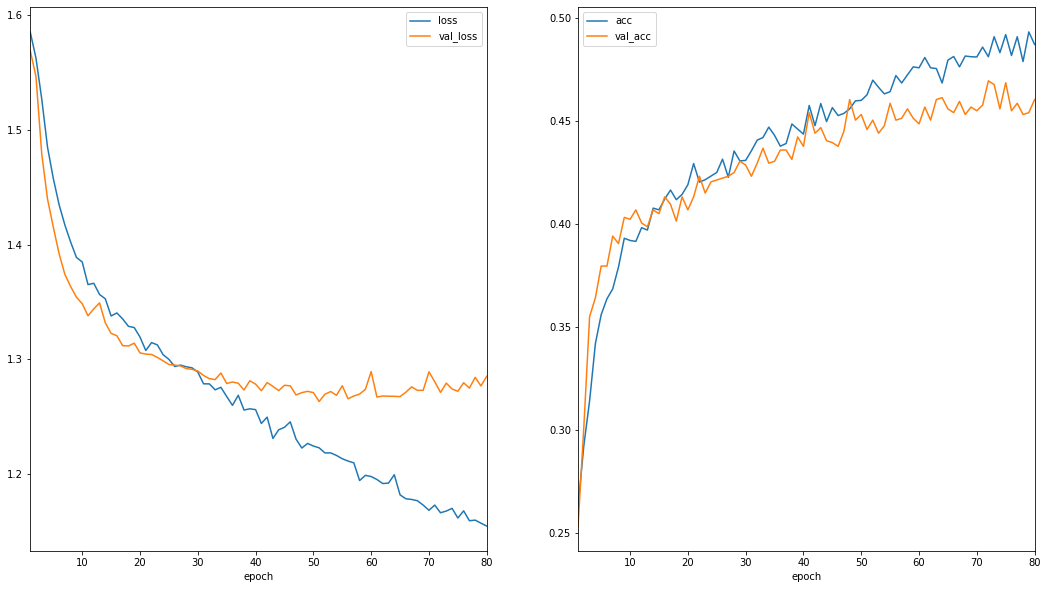

In [895]:
df = pd.DataFrame.from_dict(history.history, orient = 'index').T
df['epoch'] = df.index + 1
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize = (18, 10), sharex = True)
df.plot(x = 'epoch', y = ['loss', 'val_loss'], ax = axes[0])
df.plot(x = 'epoch', y = ['acc', 'val_acc'], ax = axes[1])
fig.savefig('deep_epochs.png')

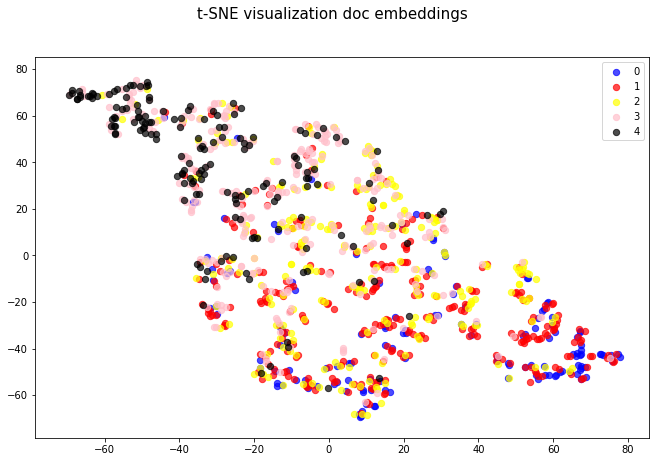

In [915]:
get_doc_embedding = K.function([model.layers[0].input, K.learning_phase()],
                                [model.layers[-2].output])
doc_embs = get_doc_embedding([np.array(X_dev),0])[0]
visualize_doc_embeddings(doc_embs,['blue','red', 'yellow', 'pink', 'black'], y_dev,'inno_emb')